In [ ]:
# Paper: Beyond Accuracy: Behavioral Testing of NLP Models with CheckList ACL 2020

# One sentence summary:
# Method to test the behaviour of NLP models through different experiments on small
# manufactured example test sets.

# Criticism:
# The authors focus mainly on English NLP models and show that the CheckList analyses
# uncover errors in commercial and openly available models. However, there is a wide usage
# of multilingual models in the NLP community for multilingual or low-resource experiments
# which makes an error analysis of multilingual models relevant and interesting.

# Planned Implementation:
# The plan is to take a multilingual model (e.g., mBERT) and create a Minimum Functionality
# Test (MFT) for testing how the model handles negations in parallel Sentiment Analysis
# sentences in English (like "It was bad.", "It was good.", "It was not good."), German ("Es war
# schlecht.", "Es war gut.", "Es war nicht gut.") and Bavarian ("Des war schlecht.", "Des war
# guad.", "Des war ned guad."). The experiments should then show whether the CheckList
# methods can also be used in a multilingual setup and whether mBERT's behaviour changes
# for different languages.

# Feedback:
# The proposal extends CheckList to other languages and implements a Minimum Functionality Test comparing English, German and Bavarian.
# Looks good. Approved.

In [ ]:
# research questions:
# can CheckList be applied to multilingual models? (only tested on English models)
# can CheckList be used to compare model capabilities across languages? (here: has the model different behaviour when handling negations in different languages)

In [ ]:
# sources

# code for data creation partly taken from 
# https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/1.%20Generating%20data.ipynb
# with major changes

# code for test creation and execution partly taken from
# https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/3.%20Test%20types%2C%20expectation%20functions%2C%20running%20tests.ipynb and
# https://github.com/marcotcr/checklist/blob/master/notebooks/tutorials/4.%20The%20CheckList%20process.ipynb
# with minor changes

# code for model training taken partly from 
# https://huggingface.co/blog/sentiment-analysis-python
# with minor changes

# code for visualisation

In [ ]:
# notes
# hard to find parallel adjective pairs where standard German and Bavarian are different -> focus on only three pairs per sentiment

# test sentences only work with predicative adjective constructions to avoid issues with inflection of the pre-chosen adjectives in standard German and Bavarian

# the tests give a good first glance at the performance, but no further error informations. 
# i visualised the predictions per label with matplotlib to get additional information about which labels fail which could be important information.
# no out-of-the-box method to access all fails, that would be handy

# running the suite with a prediction function does not allow for access to the scores, so if you need the scores themselves, you have to predict to a file
# and run the suite from the file

# result analysis English:
# some fails have to do with weather. in those cases, the sentences are labeled as neutral instead of negative. it is actually debatable if this is a fail, since
# the perception of weather is very subjective and - unless it's a natural disaster - there is no "objectively bad" weather. in the context of this test it is
# questionable whether this is a true fail or rather a design fail of the test
# sents with "stupid" tend to be labeled as negative
# the model has problems with the 4th experiment (making negative sentences positive with positive phrases)
#
# Q: do these errors show in German and Bavarian?
#

In [ ]:
# # if pip installation of CheckList fails, execute this cell
# %%bash
# git clone https://github.com/marcotcr/checklist.git
# cd checklist/
# pip install -e .

In [ ]:
# # for modernbert model install this transformers version
# !pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade

In [103]:
from checklist.editor import Editor
from checklist.test_types import MFT
from checklist.test_suite import TestSuite
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# initialise CheckList Editor objects
eng_editor = Editor() # default language = English
deu_editor = Editor(language="german")

# initialise CheckList TestSuite for running the tests
eng_suite = TestSuite()
deu_suite = TestSuite()
bar_suite = TestSuite()

In [45]:
# linguistic resources
# words chosen from the CheckList Editor suggestions

# parallel adjective lists for data creation
eng_pos = ["good", "nice", "great"]
deu_pos = ["gut", "schön", "super"]
bar_pos = ["guad", "schee", "subba"]

eng_neg = ["bad", "boring", "stupid"]
deu_neg = ["schlecht", "langweilig", "blöd"]
bar_neg = ["schlecht", "fad", "bled"]

# parallel noun lists for data creation
# picked from Editor suggestions in such a way that mostly all words are different
eng_noun = ["game", "site", "picture", "book", "story", "man", "world", "city", "time", "weather", "life"]

# standard German and Bavarian examples with determiners to avoid errors
deu_noun = [
    ("Das", "Spiel"), ("Die", "Seite"), ("Das", "Bild"), ("Das", "Buch"), ("Die", "Geschichte"), 
    ("Der", "Mann"), ("Die", "Welt"), ("Die", "Stadt"), ("Die", "Zeit"), ("Das", "Wetter"), ("Das", "Leben")
    ]

# bavarian determiners are with spaces to handle "d'" and "s'" determiners
bar_noun = [
    ("Des ", "Spui"), ("De ", "Seitn"), ("Des ", "Buidl"), ("Des ", "Buach"), ("De ", "Gschicht"), 
    ("Der ", "Mo"), ("D'", "Weid"), ("D'", "Stod"), ("D'", "Zeid"), ("S'", "Weda"), ("S'", "Lebm")
    ] 

# negative phrases
eng_neg_p = ["I hate that", "I don't like that"]
deu_neg_p = ["Ich hasse, dass", "Ich mag nicht, dass"]
bar_neg_p = ["I hass des, wenn", "I mog des ned, wenn"] # bavarian constructions work a bit differently than standard German

# positive phrases
eng_pos_p = ["I like that", "I love that"]
deu_pos_p = ["Ich mag, dass", "Ich liebe, dass"]
bar_neg_p = ["I mog des, wenn", "I liebs, wenn"]

## Word Suggestions

In [5]:
# get adj suggestions from the CheckList Editors in German and English
print("English adj suggestions: ")
print(eng_editor.suggest("This is a {mask} {noun}.", noun=["book", "movie"])[:20], "\n") 

print("German adj suggestions: ")
print(deu_editor.suggest("Das ist ein {mask} Buch.")[:20]) 
print(deu_editor.suggest("Das ist ein {mask} Film.")[:20])

English adj suggestions: 
['great', 'good', 'wonderful', 'beautiful', 'fantastic', 'terrible', 'fascinating', 'big', 'nice', 'bad', 'long', 'fun', 'scary', 'terrific', 'tough', 'short', 'serious', 'huge', 'remarkable', 'new'] 

German adj suggestions: 
['gutes', 'neues', 'großes', 'kleines', 'starkes', 'politisches', 'anderes', 'wichtiges', 'ganzes', 'besonderes', 'altes', 'deutsches', 'eigenes', 'super', 'weiteres', 'solches', 'zweites', 'einziges', 'letztes', 'erstes']
['guter', 'schlechter', 'großer', 'schöner', 'super', 'wichtiger', 'deutscher', 'schwieriger', 'historischer', 'neuer', 'kleiner', 'politischer', 'typischer', 'anderer', 'besonderer', 'amerikanischer', 'klassischer', 'einfacher', 'internationaler', 'langer']


In [7]:
# get noun suggestions from the CheckList Editors in German and English
# english suggestions
print("English noun suggestions: ")
print(eng_editor.suggest("This {mask} is {pos}.", pos=eng_pos)[:10]) 
print(eng_editor.suggest("This {mask} is {neg}.", neg=eng_neg)[:10], "\n") 

# suggestions for standard German with different determiners
print("German noun suggestions: ")
print("Der", deu_editor.suggest("Der {mask} ist {pos}.", pos=deu_pos)[:10])
print("Der", deu_editor.suggest("Der {mask} ist {neg}.", neg=deu_neg)[:10])
print("Die", deu_editor.suggest("Die {mask} ist {pos}.", pos=deu_pos)[:10])
print("Die", deu_editor.suggest("Die {mask} ist {neg}.", neg=deu_neg)[:10])
print("Das", deu_editor.suggest("Das {mask} ist {pos}.", pos=deu_pos)[:10])
print("Das", deu_editor.suggest("Das {mask} ist {neg}.", neg=deu_neg)[:10])

English noun suggestions: 
['game', 'one', 'stuff', 'book', 'article', 'video', 'post', 'movie', 'code', 'thing']
['post', 'article', 'game', 'stuff', 'video', 'movie', 'list', 'shit', 'thing', 'book'] 

German noun suggestions: 
Der ['Preis', 'Job', 'Platz', 'Service', 'Abend', 'Wind', 'Rest', 'Sieg', 'Auftritt', 'Eindruck']
Der ['Rest', 'Job', 'Film', 'Ton', 'Fußball', 'Mann', 'Preis', 'Markt', 'Anfang', 'Fall']
Die ['Stimmung', 'Atmosphäre', 'Situation', 'Sache', 'Resonanz', 'Lage', 'Idee', 'Antwort', 'Qualität', 'Zusammenarbeit']
Die ['Stimmung', 'Sache', 'Situation', 'Lage', 'Welt', 'Idee', 'Musik', 'Antwort', 'Geschichte', 'Zeit']
Das ['Ergebnis', 'Wetter', 'alles', 'Leben', 'Angebot', 'hier', 'Spiel', 'Resultat', 'Stadion', 'Essen']
Das ['Ergebnis', 'alles', 'Wetter', 'Leben', 'aber', 'Spiel', 'Ganze', 'hier', 'Auto', 'Geschäft']


## Test Creation

In [46]:
# Sanity tests
data_00 = eng_editor.template("The {noun} is {adj}.", noun=eng_noun, adj=eng_pos, labels=2) # positive samples
data_00 += eng_editor.template("The {noun} is {adj}.", noun=eng_noun, adj=eng_neg, labels=0) # negative samples
data_00_golds = data_00.labels
test = MFT(**data_00)
eng_suite.add(test, "ENG: Sanity Check", "Negation", "Simple positive and negative sentences.", overwrite=True)

In [47]:
# English tests

# test for negated positive examples, expectation: negative (0)
# e.g. The game is not good.
data01 = eng_editor.template("The {noun} is not {adj}.", noun=eng_noun, adj=eng_pos, labels=0) # not pos = negative
test = MFT(**data01)
eng_suite.add(test, "ENG: Positive Adjective Negations --> Negative", "Negation", "Sentences with negated positive adjectives.", overwrite=True)

# test for negations of positive phrases, expectation: negative (0)
# e.g. I hate that the game is good.
data02 = eng_editor.template("{p} the {noun} is {adj}.", p=eng_neg_p, noun=eng_noun, adj=eng_pos, labels=0)
test = MFT(**data02)
eng_suite.add(test, "ENG: Positive Phrase Negations --> Negative", "Negation", "Negations of positive sentences.", overwrite=True)

# test for negated negative adjectives, expectation: positive (1) (or 2)
# e.g. The game is not bad.
data03 = eng_editor.template("The {noun} is not {adj}.", noun=eng_noun, adj=eng_neg, labels=2) # not neg = positive
test = MFT(**data03)
eng_suite.add(test, "ENG: Negative Adjective Negations --> Positive", "Negation", "Sentences with negated negative adjectives.", overwrite=True)

# test for positive additional phrases to negative phrases, expectation: positive (1) (or 2)
# e.g. I like that the game is bad.
data04 = eng_editor.template("{p} the {noun} is {adj}.", p=eng_pos_p, noun=eng_noun, adj=eng_neg, labels=2)
test = MFT(**data04)
eng_suite.add(test, "ENG: Negative Phrases with Positive Additions --> Positive", "Negation", "Positive additions to negative sentences.", overwrite=True)

## Model Predictions Generation

In [25]:
# load multilingual sentiment analysis model
model_name = "clapAI/modernBERT-base-multilingual-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# initialise pipeline for predictions
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, top_k=None)

idx2lbl = model.config.id2label
lbl2idx = model.config.label2id
print(lbl2idx)
print(idx2lbl)

Device set to use cuda


{'negative': 0, 'neutral': 1, 'positive': 2}
{0: 'negative', 1: 'neutral', 2: 'positive'}


In [48]:
def predict_to_file(data, preds):
    # read data and predict
    with open(data, "r") as f:
        data = [line.strip() for line in f.readlines()]
    
    raw_preds = pipe(data)

    # write results in correct CheckList format to a file
    with open(preds, "w") as f:
        f.write("prediction positive neutral negative\n")
        for result in raw_preds:
            positive = result[0]
            neutral = result[1]
            negative = result[2]

            max_pred = max([negative, positive, neutral], key=lambda x: x["score"])
            max_label = max_pred["label"]

            f.write(f"{lbl2idx[max_label]} {positive["score"]} {neutral["score"]} {negative["score"]}\n")

In [49]:
eng_data_file = "/tmp/eng_data.txt"
eng_predictions_file = "/tmp/eng_predictions.txt"

eng_suite.to_raw_file(eng_data_file)
predict_to_file(eng_data_file, eng_predictions_file)

## CheckList Testing

In [78]:
def format_example(x, pred, conf, label, meta=None): 
    return f"Sentence: {x}\nGold: {idx2lbl[label]}\tPredicted: {idx2lbl[pred]}\tScore = {round(conf[0], 2)}"

In [79]:
eng_suite.run_from_file(eng_predictions_file, file_format="pred_and_softmax", ignore_header=True, overwrite=True)

eng_suite.summary(format_example_fn = format_example)

Negation

ENG: Sanity Check
Test cases:      66
Fails (rate):    3 (4.5%)

Example fails:
Sentence: The weather is good.
Gold: positive	Predicted: neutral	Score = 0.49
----
Sentence: The weather is bad.
Gold: negative	Predicted: neutral	Score = 0.57
----
Sentence: The weather is boring.
Gold: negative	Predicted: neutral	Score = 0.51
----


ENG: Positive Adjective Negations --> Negative
Test cases:      33
Fails (rate):    3 (9.1%)

Example fails:
Sentence: The weather is not good.
Gold: negative	Predicted: neutral	Score = 0.63
----
Sentence: The weather is not great.
Gold: negative	Predicted: neutral	Score = 0.74
----
Sentence: The weather is not nice.
Gold: negative	Predicted: neutral	Score = 0.66
----


ENG: Positive Phrase Negations --> Negative
Test cases:      66
Fails (rate):    3 (4.5%)

Example fails:
Sentence: I hate that the weather is nice.
Gold: negative	Predicted: neutral	Score = 0.56
----
Sentence: I hate that the weather is great.
Gold: negative	Predicted: neutral	Score 

## Further Analyses

In [83]:
# show all fails instead of only the three example fails

def show_all_fails(testsuite):
    for test_name, test in testsuite.tests.items():
        test_results = test.results
        test_data = list(enumerate(test.data))

        print(f"\nTest: {test_name}")

        for i, text in test_data:
            pred_label = idx2lbl[test_results["preds"][i]]
            pred_score = round(test_results["confs"][i][0], 2)

            if test_results["passed"][i] == False:
                print(f"Predicted: {pred_label}\t\tScore: {pred_score}\t\tText: {text}")

show_all_fails(eng_suite)


Test: ENG: Sanity Check
Predicted: neutral		Score: 0.49		Text: The weather is good.
Predicted: neutral		Score: 0.57		Text: The weather is bad.
Predicted: neutral		Score: 0.51		Text: The weather is boring.

Test: ENG: Positive Adjective Negations --> Negative
Predicted: neutral		Score: 0.63		Text: The weather is not good.
Predicted: neutral		Score: 0.66		Text: The weather is not nice.
Predicted: neutral		Score: 0.74		Text: The weather is not great.

Test: ENG: Positive Phrase Negations --> Negative
Predicted: neutral		Score: 0.55		Text: I hate that the weather is good.
Predicted: neutral		Score: 0.56		Text: I hate that the weather is nice.
Predicted: neutral		Score: 0.53		Text: I hate that the weather is great.

Test: ENG: Negative Adjective Negations --> Positive
Predicted: negative		Score: 0.67		Text: The site is not stupid.
Predicted: negative		Score: 0.5		Text: The picture is not stupid.
Predicted: neutral		Score: 0.41		Text: The man is not bad.
Predicted: neutral		Score: 0.43		Tex

['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative']
['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'p

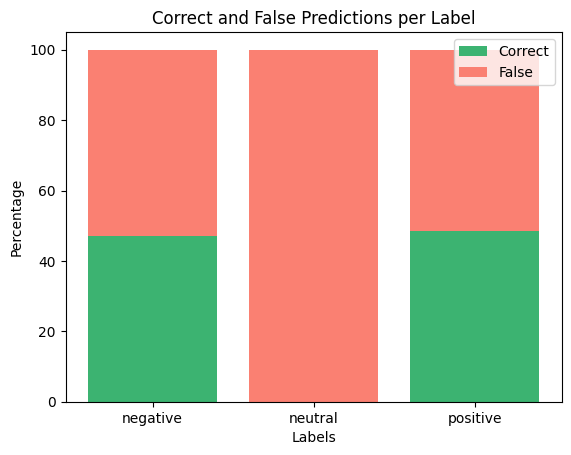

['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative']
['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'neutral', 'neutral', 'neutral', 'negative', 'negative', 'negative']
dict_keys(['negative', 'neutral', 'positive'])



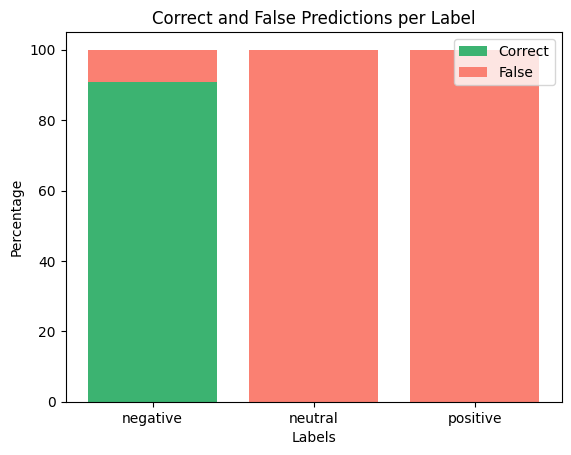

['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative']
['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'n

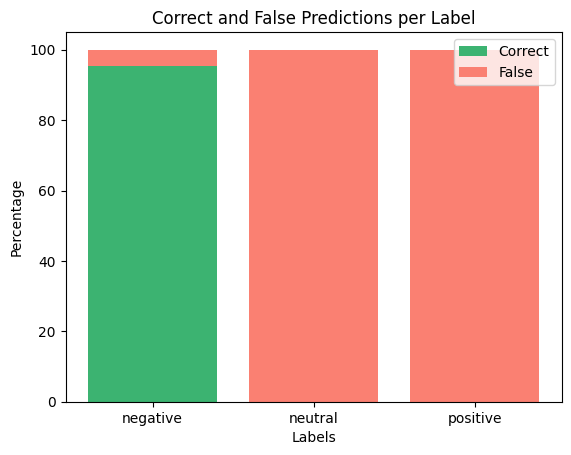

['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive']
['positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'negative', 'positive', 'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'negative']
dict_keys(['negative', 'neutral', 'positive'])



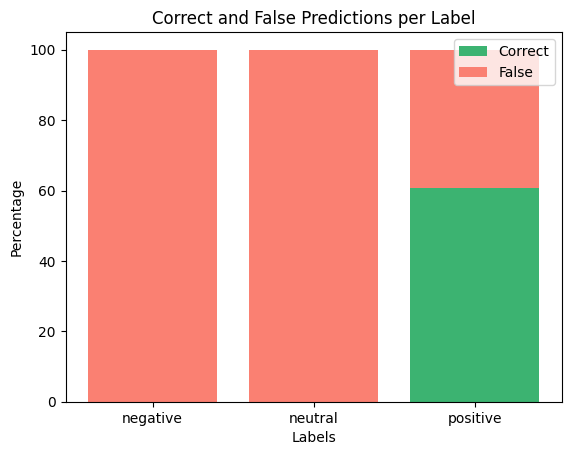

['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive']
['negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'negative', 'negative', 'n

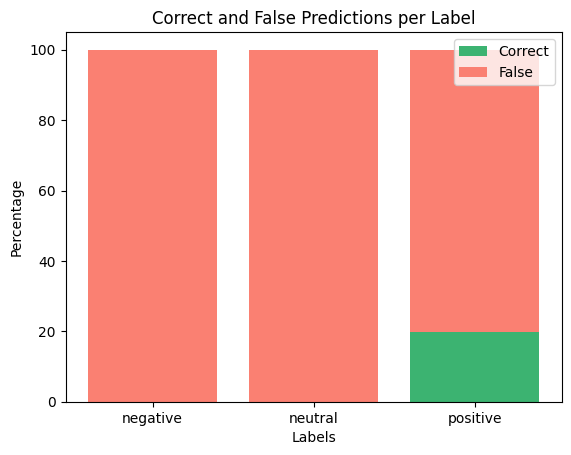

In [133]:
for test in eng_suite.tests.values():
    gold_labels = [idx2lbl[label] for label in test.labels] # convert to lexical labels for better readability
    pred_labels = [idx2lbl[label] for label in test.results["preds"]]
    
    classes = lbl2idx.keys()
    num_classes = np.arange(len(lbl2idx)) # spaced out for pyplot

    print(gold_labels)
    print(pred_labels)
    print(classes)
    print("")

    # extract counts and calculate percentages of correct and false predictions
    correct_preds_per_label = {label:0 for label in classes}
    false_preds_per_label = {label:0 for label in classes}

    for label in classes:
        for gold, pred in zip(gold_labels, pred_labels):
            if gold == label and gold == pred: # if gold is the current label and a correct prediction
                correct_preds_per_label[label] += 1

            else: 
                false_preds_per_label[label] += 1

    correct_percentages = [(count / len(gold_labels)) * 100 for count in correct_preds_per_label.values()]
    false_percentages = [(count / len(gold_labels)) * 100 for count in false_preds_per_label.values()]

    # design bar chart
    width = 0.8
    plt.bar(num_classes, correct_percentages, width, label = "Correct", color = "mediumseagreen")
    plt.bar(num_classes, false_percentages, width, bottom=correct_percentages, label = "False", color = "salmon")

    plt.xlabel("Labels")
    plt.ylabel("Percentage")
    plt.title("Correct and False Predictions per Label")
    plt.xticks(num_classes, classes)
    plt.legend()

    # plt.tight_layout()
    plt.show()

[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

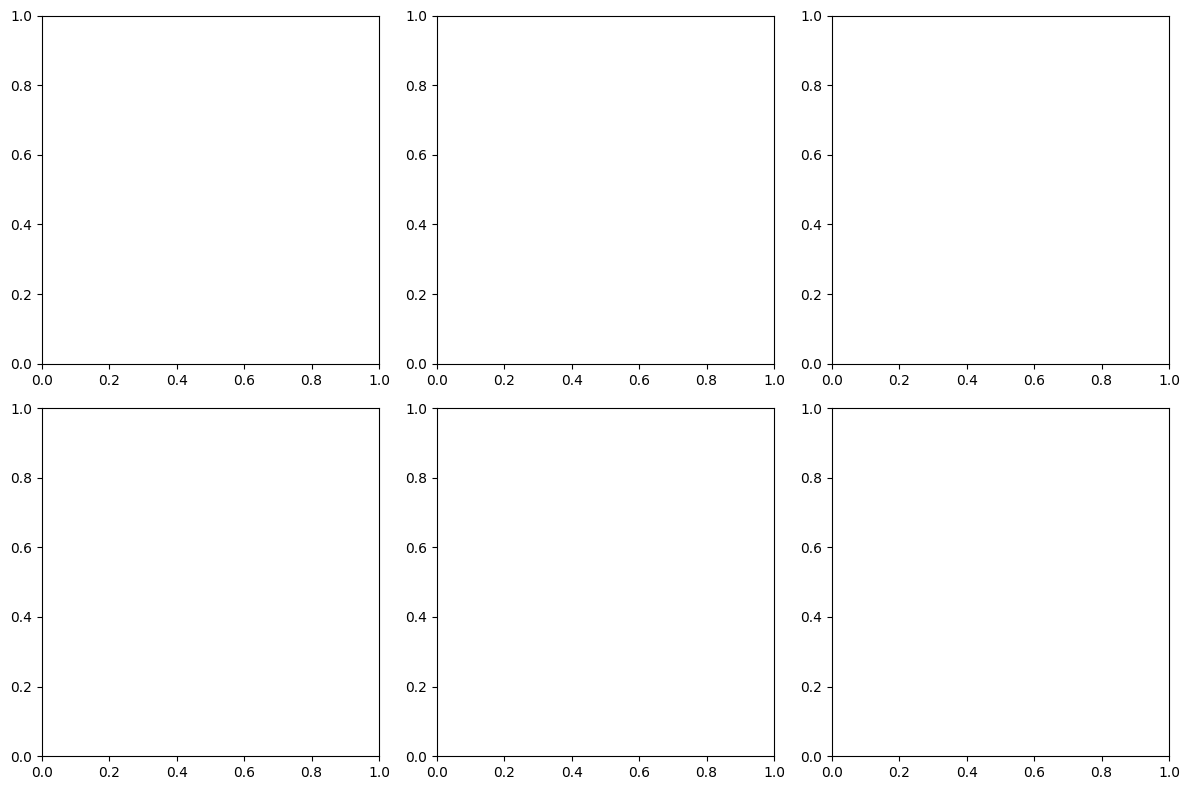

TypeError: 'int' object is not iterable

In [114]:
def visualise_testsuite(testsuite, predictions_file):
    test_names = testsuite.tests.keys()
    n_tests = len(test_names)

    # read prediction scores from given file
    with open(predictions_file, "r") as f:
        all_predictions = [line.split() for line in f][1:] # remove header line

    pred_labels = [int(item[0]) for item in all_predictions]
    pred_scores = [item[1:] for item in all_predictions]

    # get gold labels from TestSuite
    gold_labels = [test.labels for test in testsuite.tests.values()]

    # order predicted labels into tests
    ordered_pred_labels = []
    ordered_pred_scores = []
    start = 0

    for test in gold_labels:
        length = len(test)
        ordered_pred_labels.append(pred_labels[start:start+length])
        ordered_pred_scores.append(pred_scores[start:start+length])
        start += length

    print(gold_labels)
    print(ordered_pred_labels)

    # create figure with a subplot for each test
    # calculate rows and columns for the figure
    rows = int(np.sqrt(n_tests))
    cols = int(math.ceil(n_tests / rows))

    # Create the figure and axes
    _, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    # flatten the axes array for easy indexing 
    axes = axes.flatten()

    # Plot something in each subplot
    for i in range(n_tests):
        preds = ordered_pred_labels[i]
        scores = ordered_pred_scores[i]
        golds = gold_labels[i]
        


        # x = np.linspace(0, 10, 100)
        # y = np.sin(x + i)  # Example data
        # axes[i].plot(x, y)
        # axes[i].set_title(f"Plot {i + 1}")

    # hide any unused subplots
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


    # label information
    classes = lbl2idx.keys()
    num_classes = np.arange(len(classes)) # spaced out for pyplot

    # extract counts and calculate percentages of correct and false predictions
    correct_preds_per_label = {test:{label:0 for label in classes} for test in testsuite.tests}
    false_preds_per_label = {test:{label:0 for label in classes} for test in testsuite.tests}

    for label in classes:
        for i in range(0, n_tests):
            for gold, pred in zip(gold_labels[i], pred_labels[i]):
                if gold == lbl2idx[label] and gold == pred: # if gold is the current label and a correct prediction
                    correct_preds_per_label[label] += 1

                else: 
                    false_preds_per_label[label] += 1


    # TODO
    # open figure with n_test subplots
    # for test in tests, fill subplot with plot

    
    return None
    # from integer labels to text labels
    gold_labels = [idx2lbl[label] for label in golds]
    pred_labels = [idx2lbl[label] for label in preds]
    
    classes = lbl2idx.keys()
    num_classes = np.arange(len(lbl2idx)) # spaced out for pyplot

    # extract counts and calculate percentages of correct and false predictions
    correct_preds_per_label = {label:0 for label in classes}
    false_preds_per_label = {label:0 for label in classes}

    for label in classes:
        for gold, pred in zip(gold_labels, pred_labels):
            if gold == label and gold == pred: # if gold is the current label and a correct prediction
                correct_preds_per_label[label] += 1

            else: 
                false_preds_per_label[label] += 1

    correct_percentages = [(count / len(gold_labels)) * 100 for count in correct_preds_per_label.values()]
    false_percentages = [(count / len(gold_labels)) * 100 for count in false_preds_per_label.values()]

    # design bar chart
    width = 0.8
    plt.bar(num_classes, correct_percentages, width, label = "Correct", color = "mediumseagreen")
    plt.bar(num_classes, false_percentages, width, bottom=correct_percentages, label = "False", color = "salmon")

    plt.xlabel("Labels")
    plt.ylabel("Percentage")
    plt.title("Correct and False Predictions per Label")
    plt.xticks(num_classes, classes)
    plt.legend()

    # plt.tight_layout()
    plt.show()

visualise(eng_suite, eng_predictions_file)